In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LSTM, RepeatVector
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


In [2]:
train_data = pd.read_csv('/fruit classification/fruits-data/train.csv')
Y = train_data[['label']]

kf = KFold(n_splits = 5)

In [3]:
idg = ImageDataGenerator(width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.3,
                         fill_mode='nearest',
                         horizontal_flip = True,
                         rescale=1./255)

In [4]:
def get_model_name(k):
    return 'model'+str(k)+'.h5'

In [14]:
def get_model():
    model=Sequential()
    model.add(Conv2D(32, kernel_size = (3,3), 
                 padding='same',
                 input_shape=(256,256,3),
                 activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(64, kernel_size = (3,3), 
                 padding='same',
                 activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
#model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(64,activation='relu'))

    model.add(Dropout(0.2))
    model.add(Dense(32,activation='relu'))
    model.output_shape
    model.add(RepeatVector(16))
    model.add(LSTM(64,activation='tanh',return_sequences=True))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(7,activation='sigmoid'))
    
    model.summary()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model = get_model()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                16777280  
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)               

In [15]:
VALIDATION_ACCURACY = []
VALIDATTON_LOSS = []

save_dir = '/Models/'
fold_var = 1

image_dir = "/fruit classification/fruits-data/"
os.listdir(image_dir)
for train_index, val_index in kf.split(np.zeros(2107),Y):
	training_data = train_data.iloc[train_index]
	validation_data = train_data.iloc[val_index]
	
	train_data_generator = idg.flow_from_dataframe(training_data, directory = image_dir,
						       x_col = "filename", y_col = "label",
						       class_mode = "categorical", shuffle = True)
	valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = image_dir,
							x_col = "filename", y_col = "label",
							class_mode = "categorical", shuffle = True)
	
	

	
	# CREATE CALLBACKS
	checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
	callbacks_list = [checkpoint]
	
	history = model.fit(train_data_generator,
			    epochs=10,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator
				)
	
		
	model.load_weights("/Models/model"+str(fold_var)+".h5")
	
	results = model.evaluate(valid_data_generator)
	results = dict(zip(model.metrics_names,results))
	
	VALIDATION_ACCURACY.append(results['accuracy'])
	VALIDATTON_LOSS.append(results['loss'])
	
	tf.keras.backend.clear_session()
	
	fold_var += 1

Found 1685 validated image filenames belonging to 7 classes.
Found 422 validated image filenames belonging to 7 classes.
Epoch 1/10
53/53 [==============================] - 114s 2s/step - loss: 1.6203 - accuracy: 0.3478 - val_loss: 0.7770 - val_accuracy: 0.6848

Epoch 00001: val_accuracy improved from -inf to 0.68483, saving model to /Models\model1.h5
Epoch 2/10
53/53 [==============================] - 111s 2s/step - loss: 0.5437 - accuracy: 0.7834 - val_loss: 0.2094 - val_accuracy: 0.9028

Epoch 00002: val_accuracy improved from 0.68483 to 0.90284, saving model to /Models\model1.h5
Epoch 3/10
53/53 [==============================] - 111s 2s/step - loss: 0.2407 - accuracy: 0.9050 - val_loss: 0.0721 - val_accuracy: 0.9810

Epoch 00003: val_accuracy improved from 0.90284 to 0.98104, saving model to /Models\model1.h5
Epoch 4/10
53/53 [==============================] - 108s 2s/step - loss: 0.1880 - accuracy: 0.9163 - val_loss: 0.0953 - val_accuracy: 0.9692

Epoch 00004: val_accuracy did no

In [16]:
model_dir = '/Fruit Classification/Models/model_final2.h5'
model.save(model_dir)

In [17]:
from tensorflow import keras
model = keras.models.load_model(model_dir)

Accuracy: 99.99513030052185%
Output: orange


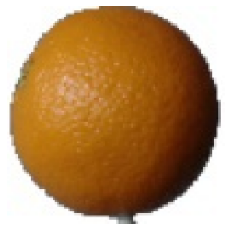

In [18]:
from tensorflow.keras.preprocessing import image
import numpy as np

test_img = image_dir + '/Orange/Orange_0.jpg'
img = image.load_img(test_img, target_size = (256,256))
img_array = image.img_to_array(img)
img_array = np.array(img_array)/255.0

train_labels = (train_data_generator.class_indices)
# Getting the labels
labels = dict((value,key) for key,value in train_labels.items())
predictions = model.predict(img_array[np.newaxis, ...])

# Displaying the output
acc = np.max(predictions[0]) * 100
print(f'Accuracy: {acc}%')
result = labels[np.argmax(predictions[0], axis = -1)]
print(f'Output: {result}')

plt.axis('off')
plt.imshow(img)

Accuracy: 99.99938011169434%
Output: avocado


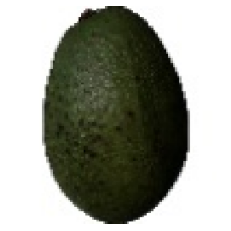

In [19]:
from tensorflow.keras.preprocessing import image
import numpy as np

test_img = image_dir + '/Avocado/Avocado_10.jpg'
img = image.load_img(test_img, target_size = (256,256))
img_array = image.img_to_array(img)
img_array = np.array(img_array)/255.0

train_labels = (train_data_generator.class_indices)
# Getting the labels
labels = dict((value,key) for key,value in train_labels.items())
predictions = model.predict(img_array[np.newaxis, ...])

# Displaying the output
acc = np.max(predictions[0]) * 100
print(f'Accuracy: {acc}%')
result = labels[np.argmax(predictions[0], axis = -1)]
print(f'Output: {result}')

plt.axis('off')
plt.imshow(img)

Accuracy: 99.96269345283508%
Output: strawberry


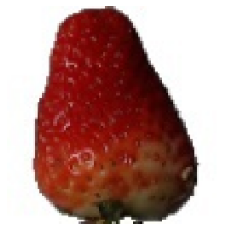

In [20]:
from tensorflow.keras.preprocessing import image
import numpy as np

test_img = image_dir + '/Strawberry/Strawberry_100.jpg'
img = image.load_img(test_img, target_size = (256,256))
img_array = image.img_to_array(img)
img_array = np.array(img_array)/255.0

train_labels = (train_data_generator.class_indices)
# Getting the labels
labels = dict((value,key) for key,value in train_labels.items())
predictions = model.predict(img_array[np.newaxis, ...])

# Displaying the output
acc = np.max(predictions[0]) * 100
print(f'Accuracy: {acc}%')
result = labels[np.argmax(predictions[0], axis = -1)]
print(f'Output: {result}')

plt.axis('off')
plt.imshow(img)